In [2310]:
import pandas as pd
from tdmsdata import TdmsData
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf
from scipy.special import erfc
from scipy.optimize import curve_fit   
from scipy.signal import fftconvolve
from scipy.stats import exponnorm
import statsmodels.api as sm
import os
import importlib
import doppler_shift_2024


In [2311]:
isotope_mapping = {
    'Sn-120': 120,
    'Sn-122': 122,
    'Sn-124': 124,
    'Sn-116': 116,
    'Sn-118': 118,
    'Sn-112': 112,
    'Sn-114': 114,
    'Sn-115': 115,
    'Sn-117': 117,
    'Sn-119': 119
}

In [2312]:
def read_tdms(folder_path, file, channel):
    TDMS = TdmsData(''.join([folder_path, file]))
    raw_data = TDMS.get_raw_data(''.join(['Channel ', str(channel)]))  # 2D np array, channel 1 = RAES, channel 3 = ID gated signal, channel 4 = ID gated bkg, channel 5 = nongated
    return raw_data

In [2313]:
def create_df(raw_data):
    return pd.DataFrame({'Cycle No.': raw_data[:, 0], 'Time (sec)': raw_data[:, 1], 
                         'Laser Frequency (THz)': raw_data[:, 2], 'Approx Time': raw_data[:, 3], # Approx time is a timestamp for calib and interferometer 
                         'SDUMP': raw_data[:, 4], 'LE Probe': raw_data[:, 5]}) # SDUMP is dump current of PREVIOUS cycle (nA) and LE probe is beam energy (V) 

In [2314]:
def doppler_shift_calc(dataset, isotope):
    importlib.reload(doppler_shift_2024)
    doppler_df = dataset.copy()
    freq = doppler_df['Laser Frequency (THz)']
    measured_voltage = doppler_df['LE Probe']
    shifted_freq = doppler_shift_2024.getshift(freq, isotope, measured_voltage)
    doppler_df['Laser Frequency (THz)'] = shifted_freq

    return doppler_df

In [ ]:
def dynamic_filters(doppler_df):
    time = 'Time (sec)'
    freq = 'Laser Frequency (THz)'

    # dynamic filter for beginning of scan?? still not sure about this one
    filtered_df = doppler_df[doppler_df[time] >= 25] # cut off first 25 s of data for when before laser is scanning. Will need to be changed for some scans ie night scans 

    # dynamic filter for end of scan
    df = filtered_df.sort_values(by=[time]).reset_index(drop=True) # first sort by time 
    
    freq_range = df[freq].max() - df[freq].min()   # Calculate the threshold based on the frequency range
    threshold = 0.9 * freq_range # 90% of the frequency range sometimes last points are not the max
    
    for i in range(len(df) - 1):
        current_freq = df.loc[i, freq]
        next_freq = df.loc[i + 1, freq]
        
        if abs(next_freq - current_freq) > threshold:
            cutoff_index = i  # Mark the index where the cutoff occurs
            break
    else:
        return df

    filtered_df = df.loc[:cutoff_index]   # Filter the data before the cutoff
    return filtered_df

In [2351]:
def triangle_filters(file, doppler_df):
    time = 'Time (sec)'
    freq = 'Laser Frequency (THz)'

    filtered_df = doppler_df[doppler_df[time] >= 25] # cut off first 25 s of data for when before laser is scanning. Will need to be changed for some scans ie night scans 

    set1_triangle = ['Sn-120_set1_ref4', 'Sn-120_set1_ref5'] # trianle scans which take 150 s to complete one side
    if any(scan in file for scan in set1_triangle):
        filtered_df = filtered_df[filtered_df[time] <= 325]
        before_175 = filtered_df[filtered_df[time] <= 175].copy()
        after_175 = filtered_df[filtered_df[time] > 175].copy()
        before_175.loc[:, 'Cycle No.'] = 1
        after_175.loc[:, 'Cycle No.'] = 2
        filtered_df = pd.concat([before_175, after_175])

    
    if 'Sn_120_set1_ref3' in file: # do the same thing as above but only first cycle is triangle 
        pass
        
    return filtered_df


In [2352]:
def get_scale(file, doppler_df):
    doppler_df = doppler_df.dropna(subset=['Laser Frequency (THz)'])

    triangle_scans = ['Sn_120_set1_ref3', 'Sn-120_set1_ref4', 'Sn-120_set1_ref5']
    if any(scan in file for scan in triangle_scans):
        filtered_df = triangle_filters(file, doppler_df)
    else: 
        filtered_df = dynamic_filters(doppler_df)

    cycle_scale = []
    grouped_cycle = filtered_df.groupby('Cycle No.')
    for cycle, group in grouped_cycle:
        cycle_data = group.groupby('Laser Frequency (THz)')['Time (sec)']
        sum_bycycle = cycle_data.sum()
        count_bycycle = cycle_data.count()
        avg_bycycle = sum_bycycle / count_bycycle
        freq_bycycle = avg_bycycle.index

        slope_cycle, intercept_cycle = np.polyfit(avg_bycycle, freq_bycycle, 1)  # unweighted linear regression
        cycle_scale.append({'cycle': cycle, 'slope': slope_cycle, 'intercept': intercept_cycle}) 
        fit_line_u = slope_cycle * avg_bycycle + intercept_cycle
        
        weights = count_bycycle # Weighted by the number of times the frequency was measured
        model = sm.WLS(freq_bycycle, sm.add_constant(avg_bycycle), weights=weights).fit()  # Add constant for intercept
        
        # Get the slope, intercept, and other statistics from the model
        slope_cycle = model.params.iloc[1]  # Use .iloc to get the slope (index 1)
        intercept_cycle = model.params.iloc[0]  # Use .iloc to get the intercept (index 0)
        r_value = model.rsquared  # Coefficient of determination (R^2)
        p_value = model.pvalues.iloc[1]  # Use .iloc to get the p-value for the slope
        std_err = model.bse.iloc[1]  # Use .iloc to get the standard error for the slope
        cycle_scale.append({'cycle': cycle, 'slope': slope_cycle, 'intercept': intercept_cycle}) 

        # Plot the results
        fit_line = slope_cycle * avg_bycycle + intercept_cycle
        plt.figure()
        plt.scatter(group['Time (sec)'], group['Laser Frequency (THz)'])
        plt.scatter(avg_bycycle, freq_bycycle, color='red', label='Average')
        plt.plot(avg_bycycle, fit_line, color='red', label='WLS Fit')
        plt.plot(avg_bycycle, fit_line_u, color='green', label = 'Unweighted')
        plt.title(f'{file} - Cycle {int(cycle)}')
        plt.legend()
        plt.show()
        
    grouped_data = filtered_df.groupby('Laser Frequency (THz)')['Time (sec)']
    sum_times = grouped_data.sum()
    count_times = grouped_data.count()
    avg_times = sum_times / count_times # gives average time for each freq
    freq = avg_times.index
    slope, intercept = np.polyfit(avg_times, freq, 1)  
    global_scale = {'slope': slope, 'intercept': intercept}
    
    # plt.figure()
    # plt.scatter(filtered_df['Time (sec)'], filtered_df['Laser Frequency (THz)'])
    # plt.show()
    
    return cycle_scale, global_scale


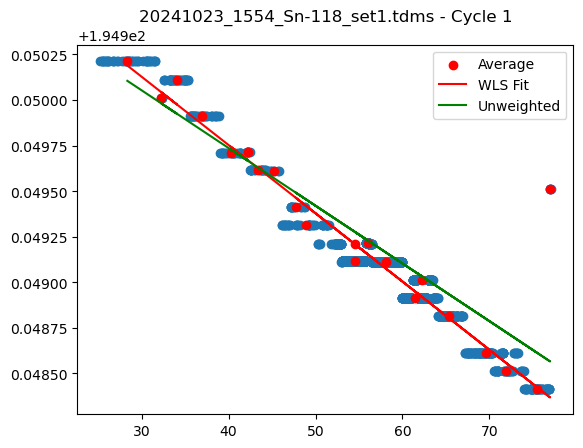

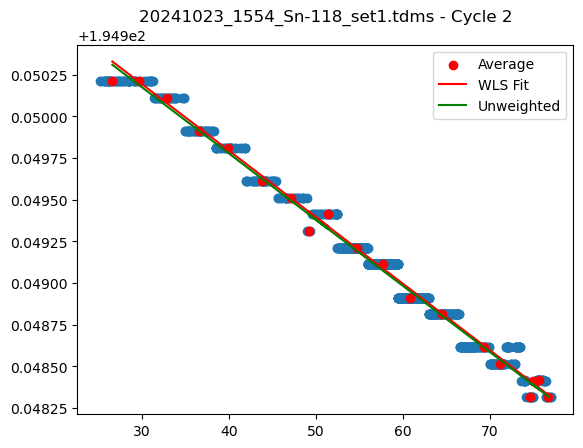

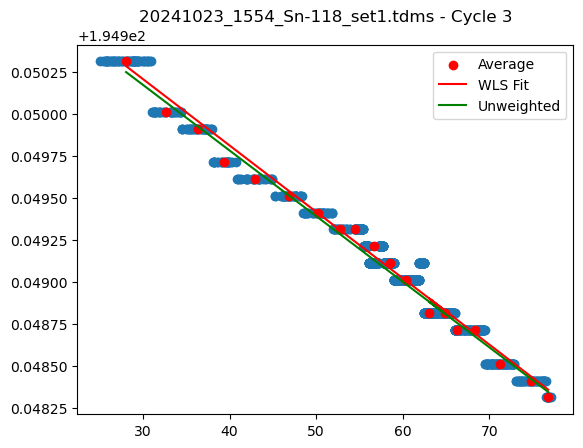

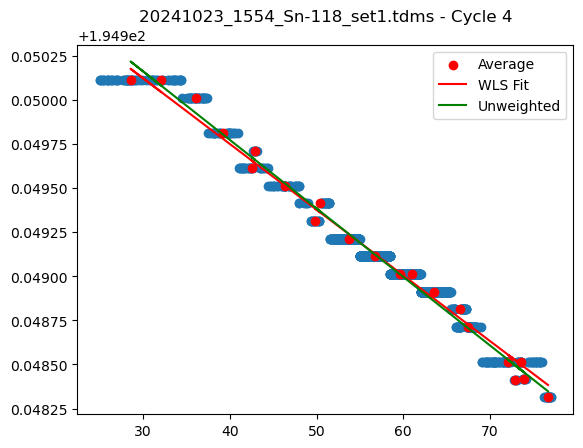

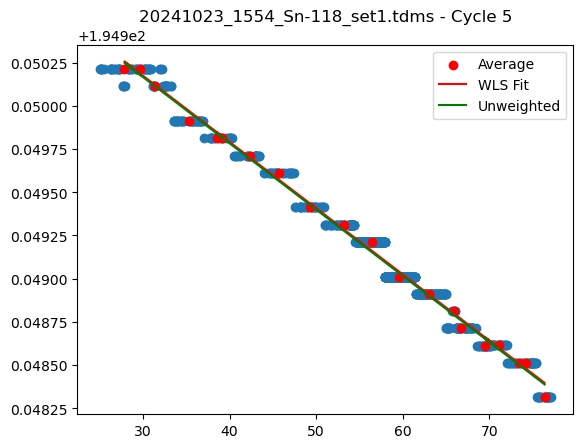

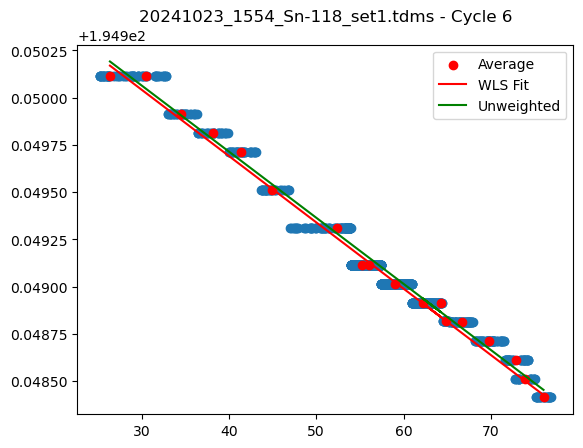

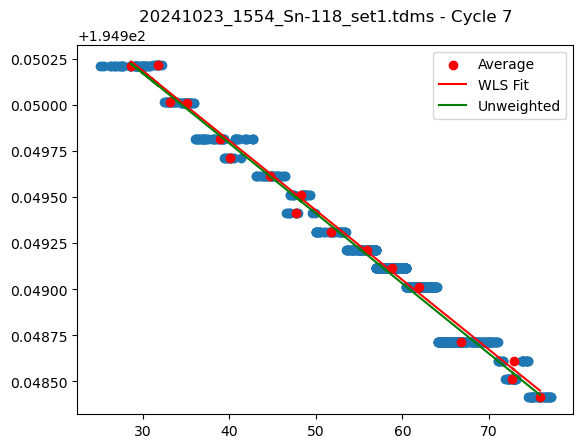

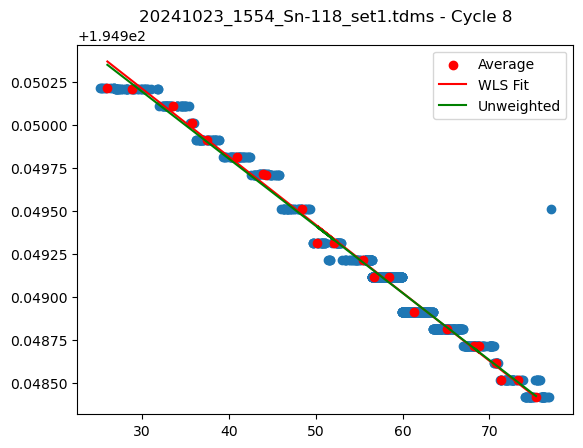

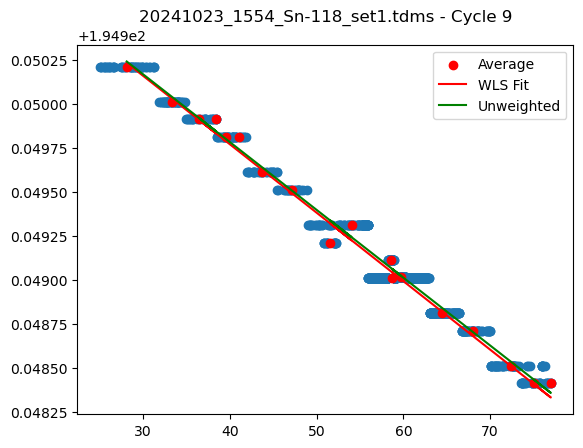

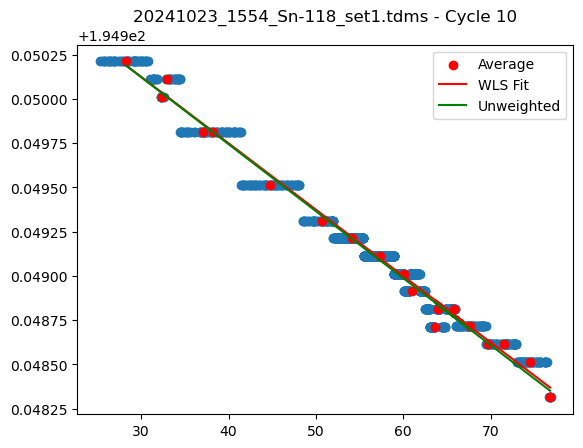

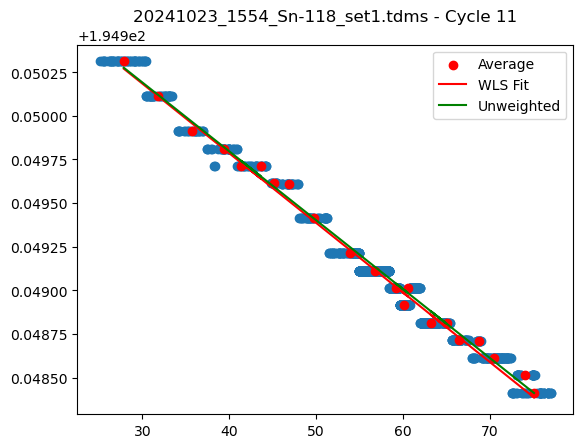

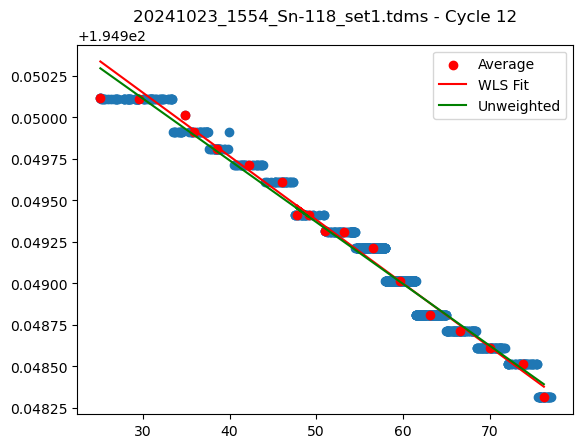

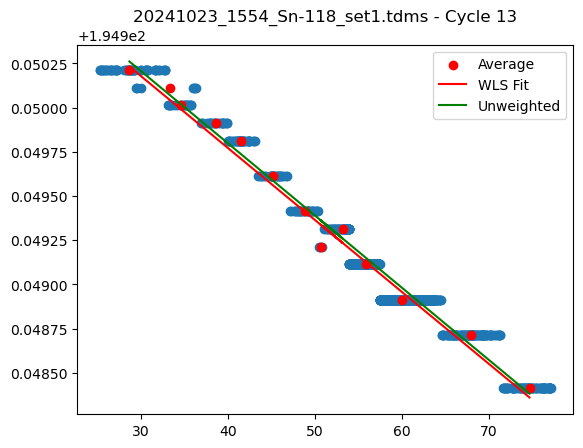

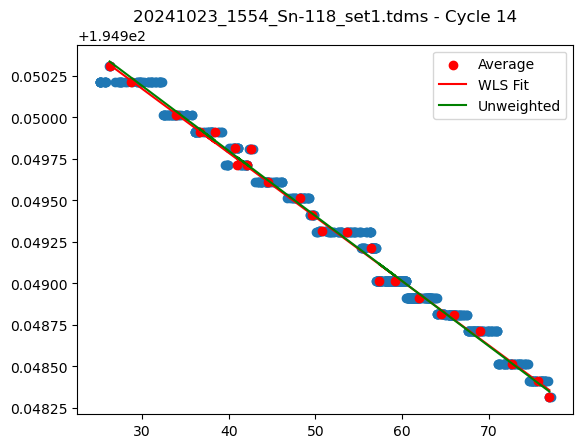

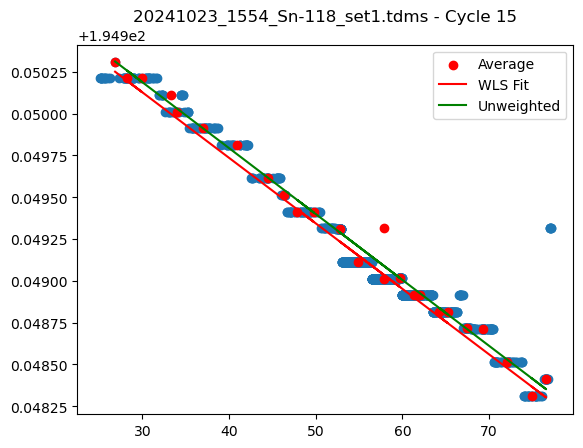

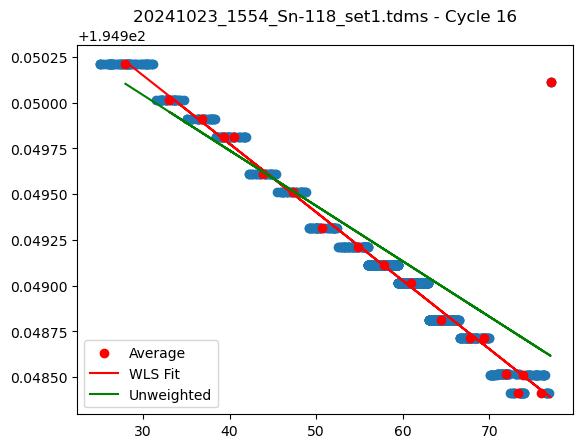

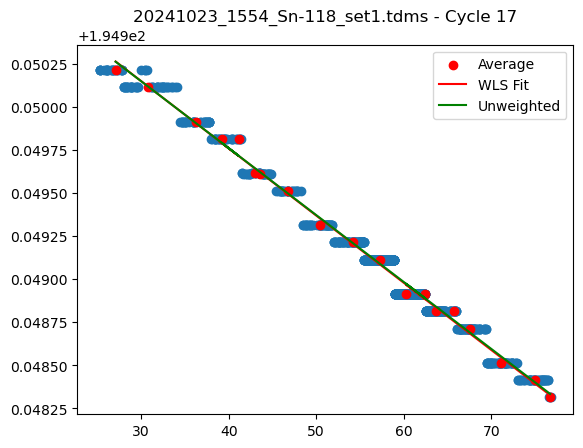

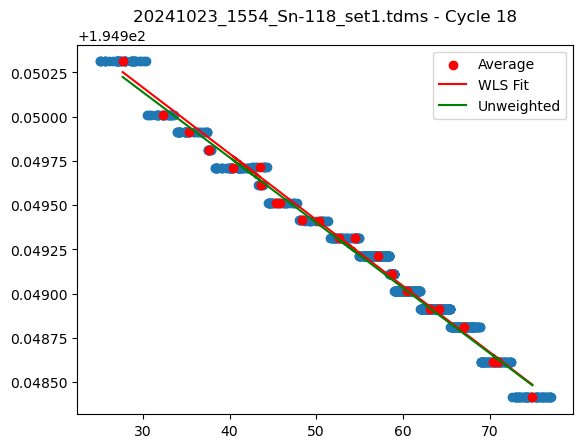

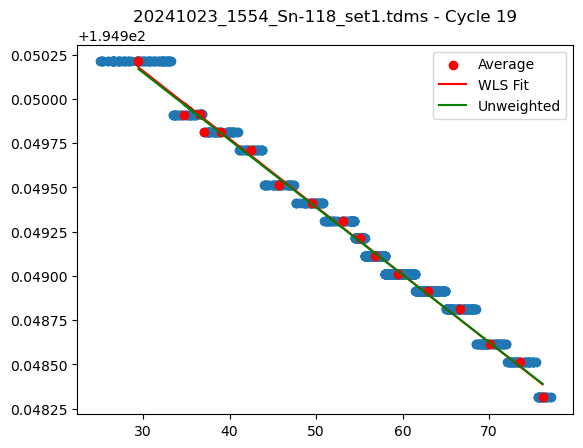

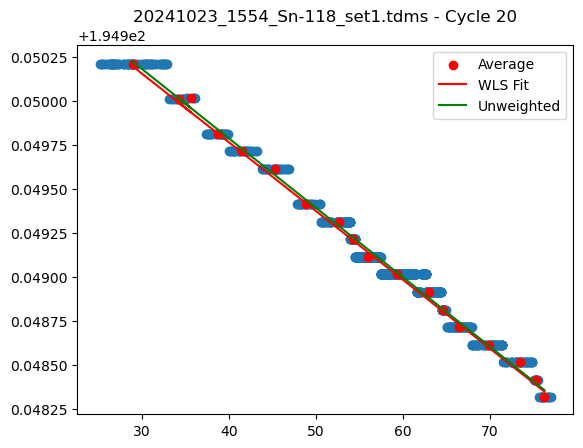

In [2353]:
folder_path = '/Users/xnimir/Desktop/Sn exp 2024/data/set1/'
for filename in os.listdir(folder_path):
        if 'Sn-118' in filename:
            isotope = next((value for key, value in isotope_mapping.items() if key in filename), None)
            raw_data = read_tdms(folder_path, filename, channel=1) 
            raw_df = create_df(raw_data)
            doppler_df = doppler_shift_calc(raw_df, isotope)
            cycle_scales, global_scale = get_scale(filename, doppler_df)

In [2340]:
def get_bkg(raw_df):
    bkg_time = 5 # s but also bin number
    bkg_df = raw_df[raw_df['Time (sec)'] <= bkg_time]  
    bkg_binned = (
        bkg_df
        .assign(Time_bin=pd.cut(bkg_df['Time (sec)'], bkg_time))  
        .groupby('Time_bin', observed=True)  
        .size() 
        .reset_index(name='Count')  
    )
    bkg = bkg_binned['Count'].mean()
    return bkg

In [2319]:
def process_dfs(raw_df, isotope, scale_info, scale):
    bkg = get_bkg(raw_df)
    
    # Filter dfs to only include when diode is scanning 
    time_threshold = 25 # sec
    filtered_df = raw_df[raw_df['Time (sec)'] >= time_threshold] # only keep data after threshold time

    # Calculate doppler shift
    doppler_df = doppler_shift_calc(filtered_df, isotope)

    # Build freq_df which consists of the unique frequencies and their counts
    freq_bins = filtered_df['Laser Frequency (THz)'].nunique() # number of unique frequencies 
    doppler_df['Laser Frequency (THz)'] = pd.to_numeric(doppler_df['Laser Frequency (THz)'], errors='coerce') # removes non-numeric values
    doppler_df = doppler_df.dropna(subset=['Laser Frequency (THz)'])

    freq_df = (
        doppler_df
        .assign(Freq_bin=pd.cut(doppler_df['Laser Frequency (THz)'], freq_bins))   
        .groupby('Freq_bin', observed=True)                               
        .size()                                                          
        .reset_index(name='Count raw')                                        
        .assign(Bin_center=lambda df: df['Freq_bin'].apply(lambda x: x.mid)) 
        .assign(count_bkg=lambda df: df['Count raw'] - bkg)
        .assign(norm_count=lambda df: df['count_bkg'] / df['count_bkg'].max())
    )
    freq_df.columns = ['Freq bin', 'Count raw', 'Bin center', 'Count-bkg', 'Norm count']
    freq_df['Bin center'] = freq_df['Bin center'].astype(float)

    # Build time_df which consists of the time bins, their counts, and bin centers
    time_bins = 50
    time_df = (
        doppler_df
        .assign(Time_bin=pd.cut(doppler_df['Time (sec)'], time_bins))    # Bin 'Time (sec)' and create 'Time_bin' column
        .groupby('Time_bin', observed=True)                               # Aggregate data within each bin
        .size()                                                           # Gives the counts for each bin 
        .reset_index(name='Count raw')                                        # Convert to DataFrame with bin counts
        .assign(Bin_center=lambda df: df['Time_bin'].apply(lambda x: x.mid))  # Calculate bin centers
        .assign(count_bkg=lambda df: df['Count raw'] - bkg)
        .assign(norm_count=lambda df: df['count_bkg'] / df['count_bkg'].max())
    )
    time_df.columns = ['Time bin', 'Count raw', 'Bin center', 'Count-bkg', 'Norm count']
    time_df['Bin center'] = time_df['Bin center'].astype(float)

    # scaling 
    scaled_bins = 50

    if scale == 'global':
        slope = scale_info['slope']
        intercept = scale_info['intercept']
        scaled_df = (
            doppler_df
            .assign(scaled_freq=lambda df: slope * df['Time (sec)'] + intercept)
            .assign(Freq_bin_scaled=lambda df: pd.cut(df['scaled_freq'], scaled_bins))   
            .groupby('Freq_bin_scaled', observed = True)
            .size()
            .reset_index(name='Count raw') 
            .assign(Bin_center=lambda df: df['Freq_bin_scaled'].apply(lambda x: x.mid))
            .assign(count_bkg=lambda df: df['Count raw'] - bkg)
        )
        scaled_df.columns = ['Freq bin', 'Count raw', 'Bin center', 'Count-bkg']
        scaled_df['Bin center'] = scaled_df['Bin center'].astype(float)


    elif scale == 'cycle':
        cycle_dfs = []
        for info_by_cycle in scale_info:
            cycle_number = info_by_cycle['cycle']
            slope = info_by_cycle['slope']
            intercept = info_by_cycle['intercept']

            cycle_df = doppler_df[doppler_df['Cycle No.'] == cycle_number] # filter for cycle
            scaled_cycle_df = (
                cycle_df
                .assign(scaled_freq=lambda df: slope * df['Time (sec)'] + intercept)
            )
            cycle_dfs.append(scaled_cycle_df)

        scaled_df = pd.concat(cycle_dfs, ignore_index=True)
        scaled_df = (
            scaled_df
            .assign(Freq_bin_scaled=lambda df: pd.cut(df['scaled_freq'], scaled_bins))
            .groupby('Freq_bin_scaled', observed=True)
            .size()
            .reset_index(name='Count raw')
            .assign(Bin_center=lambda df: df['Freq_bin_scaled'].apply(lambda x: x.mid))
            .assign(count_bkg=lambda df: df['Count raw'] - bkg)
        )
        scaled_df.columns = ['Freq bin', 'Count raw', 'Bin center', 'Count-bkg']

        scaled_df['Freq bin'] = scaled_df['Freq bin'].astype('category')  # Match global dtype
        scaled_df['Bin center'] = scaled_df['Bin center'].astype(float)
        scaled_df['Count raw'] = scaled_df['Count raw'].astype(int)
 

    
    return freq_df, time_df, scaled_df

In [2320]:
def lorentzian(x, A, x0, gamma, B=0):
    return (A / np.pi) * (gamma / ((x - x0) ** 2 + gamma ** 2)) + B

In [2321]:
def emg(x, A, x0, w, tau, B):
   z = (x - x0) / w  # Normalized variable for the Gaussian
   emg = A * (np.exp((w**2) / (2 * tau**2) - (x - x0) / tau) * 
            (1 + erf(z / np.sqrt(2) - w / (np.sqrt(2) * tau))) / 
            (tau * np.sqrt(2 * np.pi)))
   return emg + B 

In [2322]:
def pnf(x):
	"""Helper function to compute the cumulative probability for a normalized Gaussian
	
	:param x: x is scalar or array. Note that x is overwritten during the function evaluation.
	:return: probability with same shape as x
	
	The pnf is defined as the probability that x<X when X is Gaussian distributed.
	Note that for numerical stability, a different formula is used for
	positive and negative arguments.
	"""
	
	a = x < 0
	b = x >= 0
	p = x
	m_sqrt2 = np.sqrt(2)
	p[b] = ( (1 + erf(x[b] / m_sqrt2)) / 2)
	p[a] = ( (erfc(-x[a] / m_sqrt2)) / 2)
	return p



def exgausspdf(x,mu,sig,tau):
	"""Compute exponentially-modified Gaussian PDF with parameters mu, sig, and tau.
	
	:param x: x is scalar or array of values at which to compute the density.
	:param mu: scalar: central tendency.
	:param sig: scalar: symmetric variablity.
	:param tau: scalar: Exponential decay.
	:return: probability with same shape as x.
	
	"""
	# x=-(x-mu)/sig
	arg1 = (mu / tau) + ((sig**2) / (2 * (tau**2)) ) - (x / tau)
	arg2 = ((x - mu) - ((sig**2) / tau)) / sig
	f = (1 / tau) * np.exp(arg1) * pnf(arg2)
	return f


In [2323]:
def exgauss(x, mu, sigma, tau):
    exp = np.exp((sigma/np.sqrt(2)*tau)**2 + (x-mu)/tau)
    arg1 = (1/2*tau)*exp
    arg2 = erfc((sigma/np.sqrt(2)*tau) + (x-mu)/np.sqrt(2)*sigma)
    f = arg1+arg2
    return f

In [2324]:
# mu = 0
# sigma = 0.3
# tau = 1

# # Generate x values and evaluate the ex-Gaussian function
# x = np.linspace(-1, 1, 500)
# y = exgausspdf(x, mu, sigma, tau)

# plt.plot(x, y)



In [2325]:
# K, mu, sigma = 1, 1, 0.1  
# # K, mu, sigma = 0.01, 10, 0.5

# # Generate the x values for the plot
# x = np.linspace(0.825, 1, 500)
# # x = np.linspace(0,10,100)

# pdf = exponnorm.pdf(-(x-mu)/sigma, K, loc=mu, scale=sigma)
# pdf = exponnorm.pdf(x, K, loc=mu, scale=sigma)


# # Plot the ExGaussian PDF
# plt.plot(x, pdf, label='ExGaussian PDF (Left-Tail)', color='blue')
# plt.title("ExGaussian PDF with Left-Tail")
# plt.xlabel("Value")
# plt.ylabel("Density")
# plt.legend()
# plt.grid(True)
# plt.show()


In [2326]:
def get_uncertainity(counts): 
    std_err = np.sqrt(counts)
    error = std_err
    return error

In [2327]:
def gaussian(x, A, mu, sigma, B):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2)) + B

In [2328]:
def fitting(x,y):
    x_fit = np.linspace(np.min(x), np.max(x), 500)

    # lorentzian fitting
    # bounds_l = ([0, np.min(x), 0], [np.inf, np.max(x), np.inf])
    # initial_guess_l = [max(y), x[np.argmax(y)], 0.001] # 0.001 for freq, 1 for time 
    # popt, pcov = curve_fit(lorentzian, x, y, p0=initial_guess_l, bounds=bounds_l, method='dogbox')
    # A_l, mu_l, gamma_l = popt 
    # y_fit = lorentzian(x_fit, *popt)

    # emg fitting
    # bounds_emg = ([0, 0, 0, 0, 0], [np.inf, np.max(x), 1, 1, 10]) 
    # initial_guess_emg = [np.max(y), x[np.argmax(y)], 0.1/x[np.argmax(y)], 0.00001, 0] # A = amp, x0 = center, w = width, tau = decay time, B = baseline
    # print(initial_guess_emg)
    # popt, pcov = curve_fit(emg, x, y, p0=initial_guess_emg, bounds=bounds_emg)
    # A, x0, w, tau, B = popt
    # y_fit = emg(x_fit, *popt)
    # print(popt)

    initial_guess = [np.max(y), x[np.argmax(y)], np.std(x), 0]
    bounds = ([0, 0, 0, 0], [np.inf, np.max(x), np.inf, np.inf])
    popt, pcov = curve_fit(gaussian, x, y, p0=initial_guess, bounds=bounds, sigma=np.sqrt(y), absolute_sigma=True)
    y_fit = gaussian(x_fit, *popt)
    # print(initial_guess)
    # print(popt)

    return x_fit, y_fit, popt, pcov

In [2329]:
# import numpy as np

# x = np.linspace(194.948285, 194.95002, 100)
# A = 1
# x0 = 194.949
# w = 0.00005
# tau = 0.0001  

# z = (x - x0) / w  # Normalized variable for the Gaussian
# emg = A * (np.exp((w**2) / (2 * tau**2) - (x - x0) / tau) * 
#             (1 + erf(z / np.sqrt(2) - w / (np.sqrt(2) * tau))) / 
#             (tau * np.sqrt(2 * np.pi)))
# # Plot the curve
# import matplotlib.pyplot as plt
# plt.plot(x, emg)
# plt.show()


In [2330]:
def get_scatter_plot(data_df, scaled_df, scaled_bycycle_df, file):
    # unscaled data
    # x = data_df['Bin center']
    # y = data_df['Count raw']
    # x_fit, y_fit, popt, pcov = fitting(x, y)

    # scaled data
    # x_scaled = scaled_df['Bin center']
    # y_scaled = scaled_df['Count raw'] 
    # x_fit_scaled, y_fit_scaled, popt_scaled, pcov_scaled = fitting(x_scaled, y_scaled)
    # K, mu, sigma = 1, 0.95, 0.05  
    # pdf = exponnorm.pdf(-(x-mu)/sigma, K, loc=mu, scale=sigma)
    # mu = x_scaled[np.argmax(y_scaled)]
    # print(mu)
    # sigma = np.std(x_scaled)/10
    # print(sigma)
    # tau = 0.00001
    # y_fit=exgausspdf(x_scaled, mu,sigma,tau)
    

    x_scaled_bc = scaled_bycycle_df['Bin center']
    y_scaled_bc = scaled_bycycle_df['Count raw']
    x_fit_scaled_bc, y_fit_scaled_bc, popt_scaled_bc, pcov_scaled_bc = fitting(x_scaled_bc, y_scaled_bc)

    fwhm = 2.355 * popt_scaled_bc[2] * 1E6
    fit_errors = np.sqrt(np.diag(pcov_scaled_bc))
    mu_error = fit_errors[1]

    plt.errorbar(x_scaled_bc, y_scaled_bc, yerr=np.sqrt(y_scaled_bc), fmt='o', capsize=3)
    plt.plot(x_fit_scaled_bc, y_fit_scaled_bc)
    plt.title(f'{file}')
    plt.xlabel('frequency (THz)')
    plt.ylabel('binned counts')

    label = f'mu={popt_scaled_bc[1]:.6f} THz\nfwhm={fwhm:.2f} MHz'
    plt.text(0.95, 0.95, label, fontsize=10,
                        verticalalignment='top', horizontalalignment='right',
                        transform=plt.gca().transAxes) 
    plt.show()


    # plt.scatter(x, y, label = 'not scaled')
    # plt.plot(x_fit, y_fit)
    # plt.scatter(x_scaled, y_scaled, label = 'scaled')
    # plt.plot(x_fit_scaled, y_fit_scaled)
    # plt.scatter(x_scaled_bc, y_scaled_bc, label = 'scaled bycycle')
    

    # plotting
    # plt.plot(x_fit, y_fit_l, color='green')
    # plt.plot(x_fit, y_fit_emg, color='purple')
    # plt.plot(x_fit, y_fit_emg_t, color='red')
    # error = get_uncertainity(np.sqrt(np.abs(y))/data_df['Count-bkg'].max())
    # plt.errorbar(x, y, yerr=error, fmt='o', capsize=3)


    # fwhm = (gamma * 2) * 1E6 
    # error_scale = 10 ** np.floor(np.log10(mu_error))
    # mu_error_last_digit = round(mu_error / error_scale) * error_scale
    #({int(mu_error_last_digit * 1E6):d})

    return popt_scaled_bc[1], fwhm

In [2331]:
def main(folder_path):
    peaks_120 = []
    fwhms_120 = []
    peaks = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.tdms'):
            isotope = next((value for key, value in isotope_mapping.items() if key in filename), None)
            raw_data = read_tdms(folder_path, filename, channel=1) 
            raw_df = create_df(raw_data)
            doppler_df = doppler_shift_calc(raw_df, isotope)
            cycle_scales, global_scale = get_scale(filename, doppler_df)
            freq_df, time_df, scaled_df = process_dfs(raw_df, isotope, global_scale, scale='global') # one dictionary
            _, _, scaled_bycycle_df = process_dfs(raw_df, isotope, cycle_scales, scale='cycle') # list of dictionaries
            peak_freq, fwhm_freq = get_scatter_plot(freq_df, scaled_df, scaled_bycycle_df, filename)

            if isotope == 120:
                peaks_120.append(peak_freq)
                fwhms_120.append(fwhm_freq)
            else: 
                peaks.append((isotope, peak_freq))

    return peaks, peaks_120, fwhms_120


    isotopes = [item[0] for item in peaks]
    peak_freqs = [item[1] for item in peaks]
    avg_120 = np.mean(peaks_120)
    stdev = np.std(peaks_120)
    print(avg_120, stdev)

    print(isotopes, peak_freqs-avg_120)

    plt.scatter(isotopes, peak_freqs-avg_120)
    plt.show()
    plt.scatter(np.linspace(0,len(peaks_120)-1, len(peaks_120)), peaks_120)




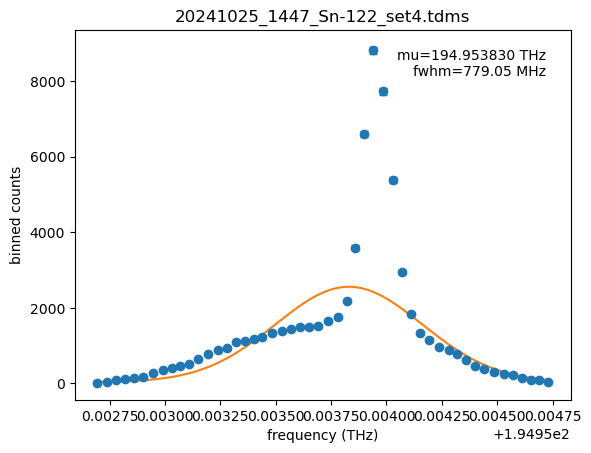

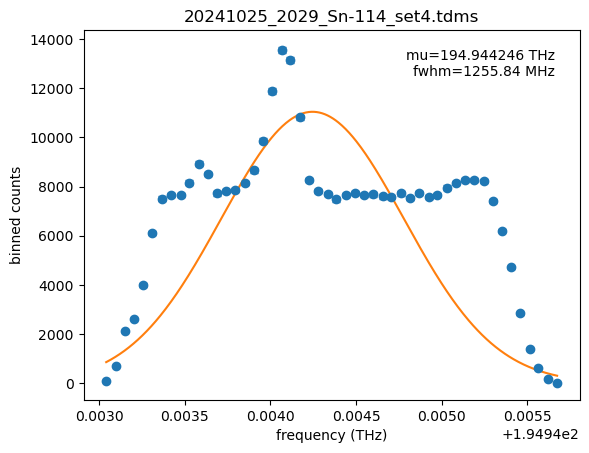

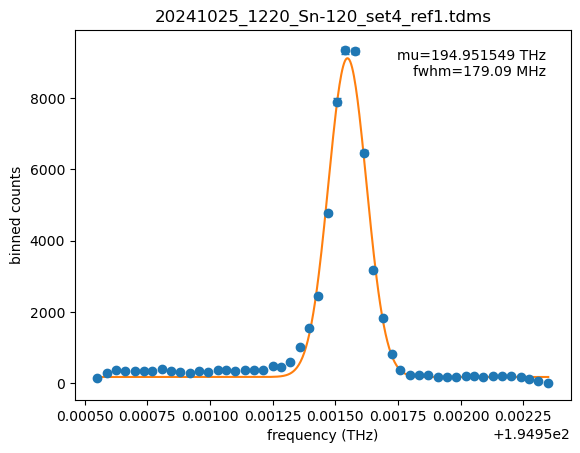

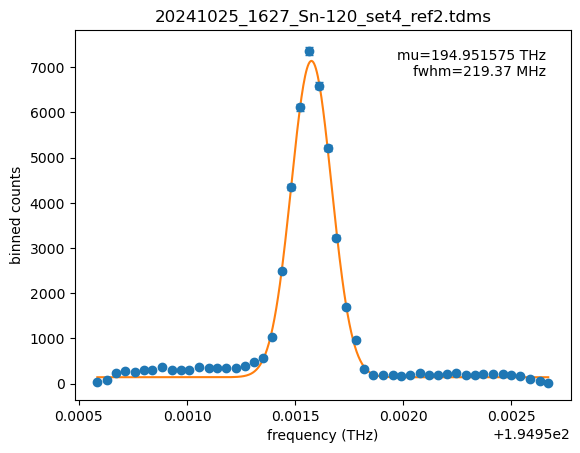

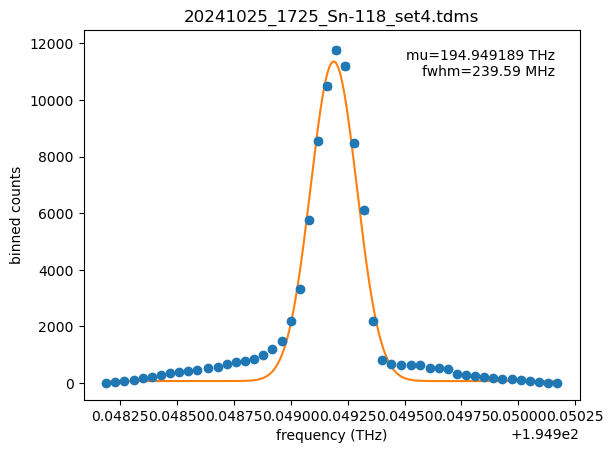

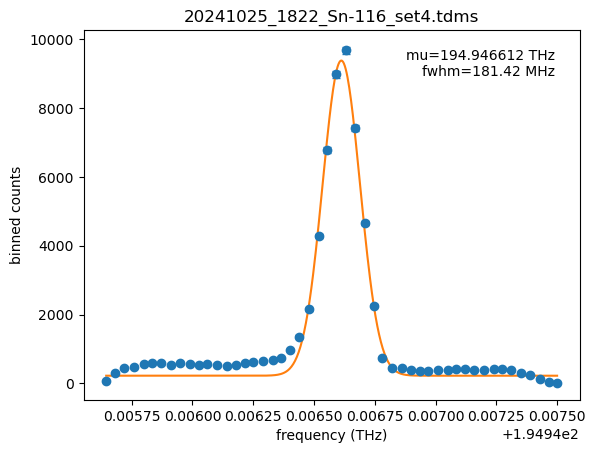

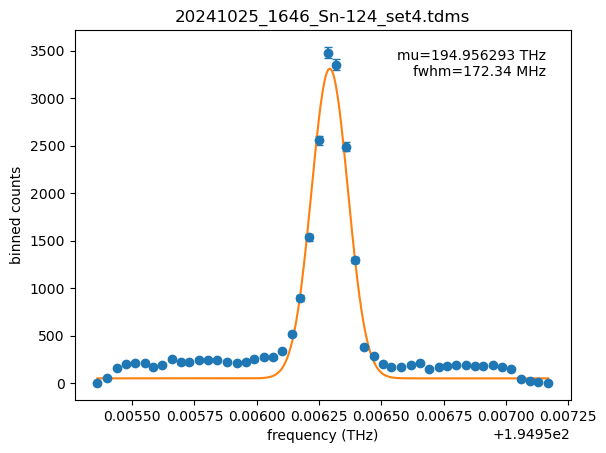

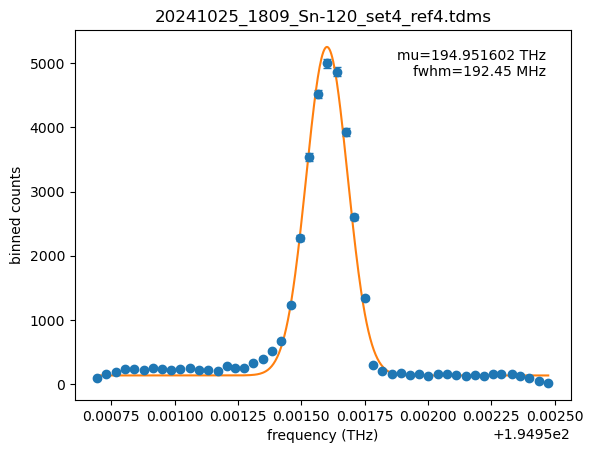

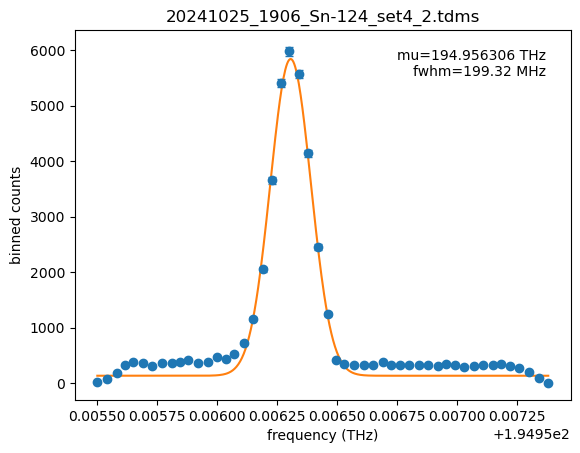

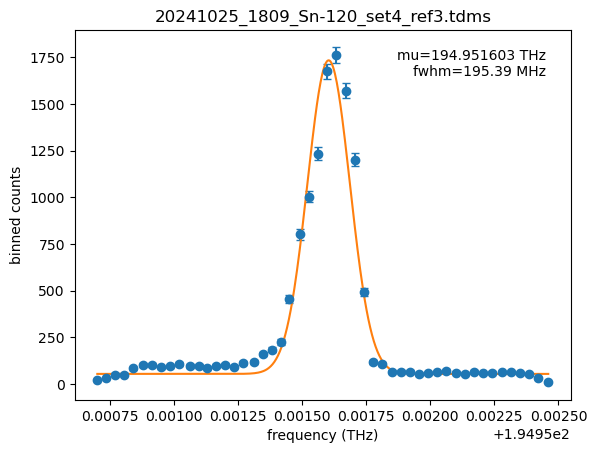

In [2332]:
def single_set():
    folder_path = '/Users/xnimir/Desktop/Sn exp 2024/data/set4/'
    main(folder_path)
single_set()

In [2333]:
def multiple_sets():
    folder_base_path = '/Users/xnimir/Desktop/Sn exp 2024/data/set'  
    results = {}
    sn120 = {}

    for set_number in range(10,11):  # iterated from n to n-1
        folder_path = f'{folder_base_path}{set_number}/'  
        
        peaks, peaks_120, fwhms_120 = main(folder_path)
        avg_120 = np.mean(peaks_120)
        stdev = np.std(peaks_120)

        sn120[set_number] = {
            'peaks_120': peaks_120,
            'fwhms_120': fwhms_120,
            'avg_120': avg_120,
            'stdev': stdev
        }

        isotopes_dict = {}  
        # isotopes =  [item[0] for item in peaks]
        for isotope, peak_freq in peaks:
            if isotope not in isotopes_dict:
                isotopes_dict[isotope] = {
                    'peak_freq': [peak_freq]
                }
            else:
                isotopes_dict[isotope]['peak_freq'].append(peak_freq)
    
        results[set_number] = {
            'isotopes': list(isotopes_dict.keys()),  # List of isotopes (keys from isotopes_dict)
            'peaks': [item['peak_freq'] for item in isotopes_dict.values()]  # List of peak frequencies for each isotope
        }
        
    isotope = 116
    set_number = 10

    isotope_index = results[set_number]['isotopes'].index(isotope)

    peak_freqs = results[set_number]['peaks'][isotope_index]
    print(peak_freqs)  

    print(results)
    print(sn120)

In [2334]:
def emg_t(x, A, x0, w, tau, E_b, gamma, B):
    z = (x - x0) / w
    emg = A * (np.exp((w**2) / (2 * tau**2) - (x - x0) / tau) *
              (1 + erf(z / np.sqrt(2) - w / (np.sqrt(2) * tau))) /
              (tau * np.sqrt(2 * np.pi)))
    
    # Thompson-Sigmund distribution for sputtered particles
    E = np.abs(x - x0)  # energy detuning
    thompson = np.where(x > x0,
                       A * gamma * E / (E + E_b)**3,  # E^(-2) tail, E_b is related to surface binding energy
                       0)
    
    total = emg + thompson
    return A * total/np.max(total) + B
    # total = gamma * emg + (1 - gamma) * thompson
    # return total + B
    
    # emg + thompson fitting
    bounds_emg_t = ([0, 0, 0, 0, 0, 0, 0], [np.max(y), np.max(x), 10, 10, 10, 1, 1]) 
    initial_guess_emg_t = [np.max(y), x[np.argmax(y)], 1, 5, 1, 1, 0] 
    popt_emg_t, pcov_emg_t = curve_fit(emg_t, x, y, p0=initial_guess_emg_t, bounds=bounds_emg_t)
    A_emg_t, x0_emg_t, w_emg_t, tau_emg_t, E_b_emg_t, gamma_emg_t, B_emg_t = popt_emg_t
    y_fit_emg_t = emg_t(x_fit, *popt_emg_t)
    # print(initial_guess_emg_t)
    # print(popt_emg_t)

In [2335]:
# xlin = np.linspace(0, 5, 5)
# yerr = np.std(peaks_120)/np.sqrt(5)

# plt.errorbar(xlin, peaks_120, yerr = yerr, fmt='o')
# plt.show()


# time = raw_df['Time (sec)']
# freq_raw = raw_df['Laser Frequency (THz)']


# plt.scatter(time,freq_raw)

In [2336]:
def plot_all(): 
    all_freqs = []
    all_counts = []
    x_fits = []
    y_fits = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.tdms'):
            isotope = next((value for key, value in isotope_mapping.items() if key in filename), None)
            raw_data = read_tdms(filename, channel=1) 
            raw_df = create_df(raw_data)
            freq_df, time_df, bkg = process_dfs(raw_df, isotope)

            freqs = freq_df['Bin center'].cat.categories.astype(float)
            counts = freq_df['Count']  

            x_fit = np.linspace(min(freqs), max(freqs), 100)
            initial_guess = [max(counts), freqs[np.argmax(counts)], 0.001]

            popt, pcov = curve_fit(lorentzian, freqs, counts, p0=initial_guess, method='dogbox')
            A, mu, gamma = popt 
            y_fit = lorentzian(x_fit, A, mu, gamma)
            fwhm = (gamma * 2) * 1E6 
    
            all_freqs.append(freqs)
            all_counts.append(counts)
            x_fits.append(x_fit)
            y_fits.append(y_fit)
            labels.append(f"Isotope {isotope}")
            
    for x_fit, y_fit, label in zip(x_fits, y_fits, labels):
        plt.plot(x_fit, y_fit, label=label) 

    plt.xlabel('Frequency (THz)')  
    plt.ylabel('Count') 
    plt.legend()  
    plt.show()


In [2337]:
# if 'Sn-122_set4' or 'Sn-116_set4':
    #     counts_df = counts_df.iloc[2:].reset_index(drop=True)

    # if 'Sn-120_set5_ref1' in file: 
    #     counts_df = counts_df.iloc[:-2].reset_index(drop=True) # verified 
    # if 'Sn-120_set5_ref2' in file: 
    #     counts_df = counts_df.iloc[1:-4].reset_index(drop=True) 
    # if 'Sn-120_set5_ref6' in file: 
    #     counts_df = counts_df.iloc[:-4].reset_index(drop=True) 
    # if 'Sn-116_set5' in file: 
    #     counts_df = counts_df.iloc[:-4].reset_index(drop=True) 
    # if 'Sn-122_set5' in file: 
    #     counts_df = counts_df.sort_values(by='Count', ascending=True).reset_index(drop=True)
    #     counts_df = counts_df.iloc[:-1].reset_index(drop=True)
    #     counts_df = counts_df.sort_values(by='Freq', ascending=True).reset_index()

    # if 'Sn-122_set6' in file: 
    #     counts_df.iloc[-3:-1,1] = 200 # trying out replacing injection and decay with bkg 
    # if 'Sn-124_set6' in file: 
    #     counts_df = counts_df.sort_values(by='Count', ascending=True).reset_index(drop=True)
    #     counts_df = counts_df.iloc[:-1].reset_index(drop=True)
    #     counts_df = counts_df.sort_values(by='Freq', ascending=True).reset_index()
    # if 'Sn-120_set6_ref2' in file: 
    #     counts_df = counts_df.iloc[:-2].reset_index(drop=True) # verified  
    # if 'Sn-118_set6' in file or 'set6_ref3' in file: 
    #     counts_df = counts_df.sort_values(by='Count', ascending=True).reset_index(drop=True)
    #     counts_df = counts_df.iloc[:-1].reset_index(drop=True)
    # if 'Sn-116_set6' in file: 
    #     counts_df.iloc[-4:-1,1] = 6

    # # if 'set7_ref2' not in file: 
    # #     counts_df.iloc[-3:-1,1] = counts_df.iloc[-1, 1] # attempting to get rid of inj and depletion for any file 


    # if 'Sn-122_set8' in file:
    #     counts_df.iloc[-5:-4,1] = 100
    # if 'Sn-118_set8' in file or 'Sn-116_set8' in file: 
    #     counts_df = counts_df.sort_values(by='Count', ascending=True).reset_index(drop=True)
    #     counts_df = counts_df.iloc[:-1].reset_index(drop=True)
    # if 'Sn-120_set8_ref3' in file:
    #     counts_df.iloc[-3:-1,1] = 80

    # if 'Sn-120_set9_ref1' in file:
    #     counts_df.iloc[-3:-1,1] = 20



    # if 'Sn-120_set5_ref3' in file: 
    #     # counts_df = counts_df.iloc[:-6].reset_index(drop=True) # to filter out weird freqs from set 5
    #     counts_df = counts_df.sort_values(by='Count', ascending=True).reset_index(drop=True)
    #     counts_df = counts_df.iloc[:-2].reset_index(drop=True)

    # if 'Sn-120_set5_ref4' in file: 
    #     counts_df = counts_df.sort_values(by='Count', ascending=True).reset_index(drop=True)
    #     counts_df = counts_df.iloc[:-1].reset_index(drop=True) 

        # min_freq = 194.9505
        # max_freq = 194.9525
        # counts_df = counts_df[(counts_df['Freq'] < min_freq) | (counts_df['Freq'] > max_freq)].reset_index(drop=True)

    # this is to look at the DF before the doppler shift to make sure binning is correct from processing dfs
    # counts_df = (
    #     pd.to_numeric(filtered_df['Laser Frequency (THz)'], errors='coerce')  # Convert to numeric, set non-numeric to NaN
    #     .dropna()                                                         # Remove NaN values
    #     .value_counts()                                                   # Count unique frequencies
    #     .reset_index()                                                    # Convert from series to DataFrame by changing index to column
    #     )

    # # Rename columns now to clarify them
    # counts_df.columns = ['Freq', 'Count']

    # # Sort by the 'Freq' column
    # counts_df = counts_df.sort_values(by='Freq').reset_index(drop=True)
    # print(counts_df)
    # print(freq_df)



In [2338]:
# for testing convolution of EMG and Thompson

# # Define the EMG function
# def emg(x, A, x0, w, tau, B):
#     z = (x - x0) / w  # Normalized variable for Gaussian
#     emg = A * (np.exp((w**2) / (2 * tau**2) - (x - x0) / tau) * 
#                (1 + erf(z / np.sqrt(2) - w / (np.sqrt(2) * tau))) /
#                (tau * np.sqrt(2 * np.pi)))
#     return A * emg / np.max(emg) + B

# # Define the Thompson distribution
# def thompson(x, A, x0, E_b, B):
#     E = np.abs(x - x0)  # Energy detuning
#     thompson = np.where(x > x0, A * E / (E + E_b)**3, 0)
#     return A * thompson / np.max(thompson) + B

# # Set parameters
# A, x0, w, tau, E_b, B = 1.0, 0.0, 0.5, 2.0, 0.1, 0.1
# x = np.linspace(-2, 5, 500)  # Define x range

# # Compute values
# emg_values = emg(x, A, x0, w, tau, B)
# thompson_values = thompson(x, A, x0, E_b, B)

# # Find non-zero regions
# emg_nonzero = x[emg_values > 1e-5]  # Small threshold for EMG
# thompson_nonzero = x[thompson_values > 1e-5]  # Small threshold for Thompson

# # Check for overlap
# overlap = np.intersect1d(emg_nonzero, thompson_nonzero)

# # Plot results
# plt.figure(figsize=(10, 6))
# plt.plot(x, emg_values, label="EMG", color='blue')
# plt.plot(x, thompson_values, label="Thompson", color='red')
# plt.axvline(x0, color='gray', linestyle='--', label="x0")
# plt.fill_between(x, 0, emg_values, where=(x > x0), color='blue', alpha=0.3, label="EMG Tail")
# plt.fill_between(x, 0, thompson_values, where=(x > x0), color='red', alpha=0.3, label="Thompson Region")
# plt.title("EMG and Thompson Distributions")
# plt.xlabel("x")
# plt.ylabel("Value")
# plt.legend()
# plt.show()

# print(f"Overlap range: {overlap if len(overlap) > 0 else 'No overlap'}")
